In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Uterus/')]
groups = ['Histone', 'TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Uterus/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/244 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("uterus.bed", "r") as bed_file:
    for line in bed_file:
        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
win_in = []
win_out = []
width = 5000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
win_in[:10]

[['chr1', 192325183, 192330183],
 ['chr1', 52552255, 52557255],
 ['chr1', 199498305, 199503305],
 ['chr1', 42982978, 42987978],
 ['chr1', 58669636, 58674636],
 ['chr1', 185065032, 185070032],
 ['chr1', 16889426, 16894426],
 ['chr1', 191273554, 191278554],
 ['chr1', 54508116, 54513116],
 ['chr1', 151583321, 151588321]]

In [7]:
win_out[:10]

[['chr1', 192225183, 192230183],
 ['chr1', 192175183, 192180183],
 ['chr1', 192150183, 192155183],
 ['chr1', 192175183, 192180183],
 ['chr1', 192225183, 192230183],
 ['chr1', 192325183, 192330183],
 ['chr1', 52452255, 52457255],
 ['chr1', 52402255, 52407255],
 ['chr1', 52377255, 52382255],
 ['chr1', 52402255, 52407255]]

In [8]:
print(len(win_in), len(win_out))

4147 24770


In [9]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in) * 2, replace=False)]

In [10]:
print(len(ints_in1), len(ints_out1))

4147 8294


In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr2', '3723241', '3728241', '0'],
       ['chr9', '16567115', '16572115', '1'],
       ['chr6', '85712284', '85717284', '1'],
       ['chr1', '248481748', '248486748', '0'],
       ['chr7', '84588438', '84593438', '0'],
       ['chr8', '40645785', '40650785', '0'],
       ['chr12', '27835540', '27840540', '0'],
       ['chr10', '80494995', '80499995', '0'],
       ['chr11', '16905656', '16910656', '0'],
       ['chr1', '175964533', '175969533', '0']], dtype='<U21')

In [12]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12441/12441 [01:13<00:00, 169.25it/s]


In [13]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [14]:
X = np.array(X)
X

array([[-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       ...,
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202]], dtype=float32)

In [15]:
X.shape

(12441, 244)

In [16]:
y

tensor([0, 1, 1,  ..., 0, 0, 1])

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


2023-05-16 14:51:50.760788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 14:51:51.360798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10
311/311 [==============================] - 4s 12ms/step - loss: 0.6413 - accuracy: 0.6673 - val_loss: 0.6441 - val_accuracy: 0.6605
Epoch 2/10
311/311 [==============================] - 3s 11ms/step - loss: 0.6362 - accuracy: 0.6682 - val_loss: 0.6430 - val_accuracy: 0.6605
Epoch 3/10
311/311 [==============================] - 3s 11ms/step - loss: 0.6361 - accuracy: 0.6682 - val_loss: 0.6422 - val_accuracy: 0.6605
Epoch 4/10
311/311 [==============================] - 4s 11ms/step - loss: 0.6357 - accuracy: 0.6682 - val_loss: 0.6419 - val_accuracy: 0.6605
Epoch 5/10
311/311 [==============================] - 4s 11ms/step - loss: 0.6355 - accuracy: 0.6682 - val_loss: 0.6409 - val_accuracy: 0.6605
Epoch 6/10
311/311 [==============================] - 4s 11ms/step - loss: 0.6358 - accuracy: 0.6685 - val_loss: 0.6408 - val_accuracy: 0.6605
Epoch 7/10
311/311 [==============================] - 3s 11ms/step - loss: 0.6357 - accuracy: 0.6683 - val_loss: 0.6406 - val_accuracy: 0.6605

In [18]:
X

array([[-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       ...,
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202],
       [-0.10309448, -0.01636233, -0.08444732, ..., -0.07969937,
        -0.04046951, -0.04490202]], dtype=float32)

In [19]:
y

tensor([0, 1, 1,  ..., 0, 0, 1])

In [20]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [21]:
X = X_copy
y = y_copy

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_996/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_996/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6368, Train F1-score: 0.4050, Train ROC-AUC: 0.4127, Train PR-AUC: 0.3823, Test Loss: 0.6387, Test F1-score: 0.5438, Test ROC-AUC: 0.5154, Test PR-AUC: 0.3672
Epoch [2/20], Train Loss: 0.6283, Train F1-score: 0.5602, Train ROC-AUC: 0.5182, Train PR-AUC: 0.4902, Test Loss: 0.6409, Test F1-score: 0.5543, Test ROC-AUC: 0.5155, Test PR-AUC: 0.3702
Epoch [3/20], Train Loss: 0.6229, Train F1-score: 0.5602, Train ROC-AUC: 0.3636, Train PR-AUC: 0.2342, Test Loss: 0.6439, Test F1-score: 0.5487, Test ROC-AUC: 0.5129, Test PR-AUC: 0.3656
Epoch [4/20], Train Loss: 0.6149, Train F1-score: 0.8482, Train ROC-AUC: 0.8333, Train PR-AUC: 0.5903, Test Loss: 0.6542, Test F1-score: 0.5532, Test ROC-AUC: 0.5035, Test PR-AUC: 0.3534
Epoch [5/20], Train Loss: 0.6068, Train F1-score: 0.8167, Train ROC-AUC: 0.4643, Train PR-AUC: 0.1061, Test Loss: 0.6700, Test F1-score: 0.5532, Test ROC-AUC: 0.5131, Test PR-AUC: 0.3568
Epoch [6/20], Train Loss: 0.5972, Train F1-score: 0.5288, Train R

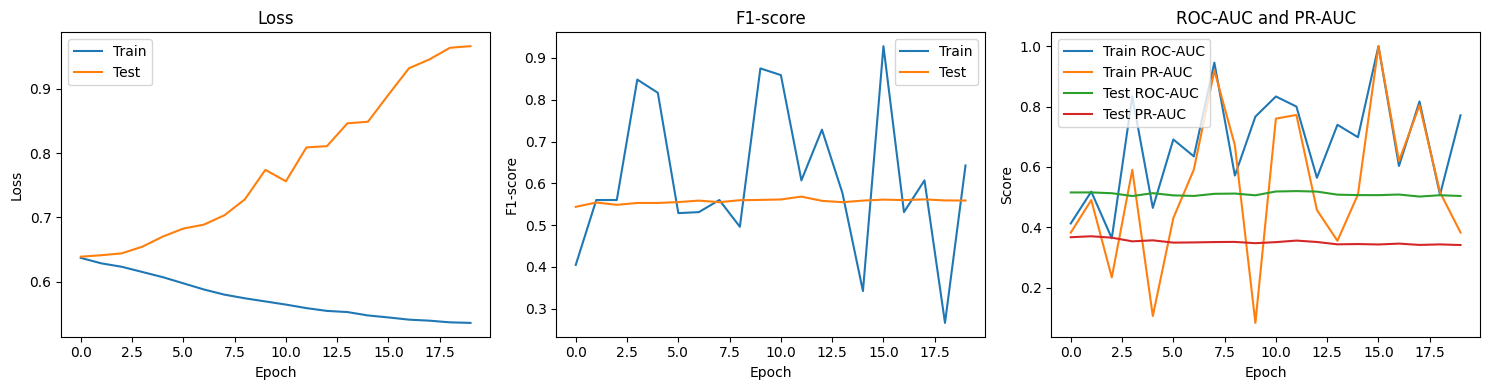

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_996/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_996/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6802, Train F1-score: 0.5730, Train ROC-AUC: 0.5079, Train PR-AUC: 0.3455, Test Loss: 0.6583, Test F1-score: 0.5448, Test ROC-AUC: 0.5109, Test PR-AUC: 0.3482
Epoch [2/20], Train Loss: 0.6425, Train F1-score: 0.5646, Train ROC-AUC: 0.5160, Train PR-AUC: 0.3538, Test Loss: 0.6442, Test F1-score: 0.5408, Test ROC-AUC: 0.5119, Test PR-AUC: 0.3538
Epoch [3/20], Train Loss: 0.6355, Train F1-score: 0.5585, Train ROC-AUC: 0.5215, Train PR-AUC: 0.3647, Test Loss: 0.6416, Test F1-score: 0.5365, Test ROC-AUC: 0.5114, Test PR-AUC: 0.3556
Epoch [4/20], Train Loss: 0.6334, Train F1-score: 0.5543, Train ROC-AUC: 0.5212, Train PR-AUC: 0.3688, Test Loss: 0.6406, Test F1-score: 0.5356, Test ROC-AUC: 0.5140, Test PR-AUC: 0.3582
Epoch [5/20], Train Loss: 0.6314, Train F1-score: 0.5549, Train ROC-AUC: 0.5320, Train PR-AUC: 0.3782, Test Loss: 0.6401, Test F1-score: 0.5365, Test ROC-AUC: 0.5154, Test PR-AUC: 0.3617
Epoch [6/20], Train Loss: 0.6325, Train F1-score: 0.5539, Train R

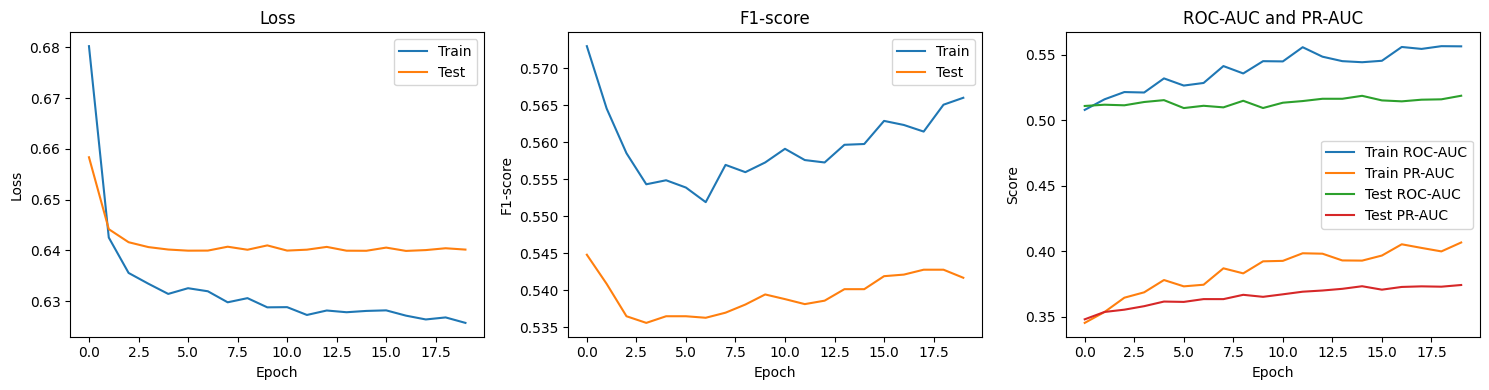

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature TFs_PAX2 importance: 0.0016070711128967075
Feature TFs_TFAM importance: 0.0016070711128967075
Feature Histone_H3K36me3 importance: 0.0012053033346726139
Feature TFs_FAM208A importance: 0.0012053033346726139
Feature TFs_FANCM importance: 0.0012053033346726139
Feature TFs_HJURP importance: 0.0012053033346726139
Feature TFs_MAPK1 importance: 0.0012053033346726139
Feature TFs_MRE11A importance: 0.0012053033346726139
Feature Histone_H4K20me3 importance: 0.0008035355564484092
Feature Histone_H4K20me1 importance: 0.0008035355564484092
Feature Histone_H2BS112GlcNAc importance: 0.0008035355564484092
Feature TFs_AHR importance: 0.0008035355564484092
Feature TFs_ARNT importance: 0.0008035355564484092
Feature TFs_DEK importance: 0.0008035355564484092
Feature TFs_EPCAM importance: 0.0008035355564484092
Feature TFs_EZH2 importance: 0.0008035355564484092
Feature TFs_KANSL1 importance: 0.0008035355564484092
Feature TFs_MLXIP importance: 0.0008035355564484092
Feature TFs_SMARCC2 importance: 0.0

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_996/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_996/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6398, Train F1-score: 0.6429, Train ROC-AUC: 0.7917, Train PR-AUC: 0.4066, Test Loss: 0.6447, Test F1-score: 0.5367, Test ROC-AUC: 0.5036, Test PR-AUC: 0.3556
Epoch [2/20], Train Loss: 0.6334, Train F1-score: 0.6429, Train ROC-AUC: 0.5208, Train PR-AUC: 0.2546, Test Loss: 0.6422, Test F1-score: 0.5406, Test ROC-AUC: 0.5099, Test PR-AUC: 0.3620
Epoch [3/20], Train Loss: 0.6331, Train F1-score: 0.4050, Train ROC-AUC: 0.4286, Train PR-AUC: 0.3642, Test Loss: 0.6436, Test F1-score: 0.5376, Test ROC-AUC: 0.5035, Test PR-AUC: 0.3577
Epoch [4/20], Train Loss: 0.6294, Train F1-score: 0.5288, Train ROC-AUC: 0.6545, Train PR-AUC: 0.4407, Test Loss: 0.6399, Test F1-score: 0.5371, Test ROC-AUC: 0.5190, Test PR-AUC: 0.3713
Epoch [5/20], Train Loss: 0.6320, Train F1-score: 0.7284, Train ROC-AUC: 0.3590, Train PR-AUC: 0.4234, Test Loss: 0.6397, Test F1-score: 0.5386, Test ROC-AUC: 0.5143, Test PR-AUC: 0.3729
Epoch [6/20], Train Loss: 0.6315, Train F1-score: 0.4808, Train R

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_996/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_996/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6366, Train F1-score: 0.5609, Train ROC-AUC: 0.5147, Train PR-AUC: 0.3595, Test Loss: 0.6415, Test F1-score: 0.5488, Test ROC-AUC: 0.5062, Test PR-AUC: 0.3635
Epoch [2/20], Train Loss: 0.6275, Train F1-score: 0.5700, Train ROC-AUC: 0.5494, Train PR-AUC: 0.3982, Test Loss: 0.6405, Test F1-score: 0.5504, Test ROC-AUC: 0.5087, Test PR-AUC: 0.3667
Epoch [3/20], Train Loss: 0.6243, Train F1-score: 0.5810, Train ROC-AUC: 0.5640, Train PR-AUC: 0.4145, Test Loss: 0.6436, Test F1-score: 0.5540, Test ROC-AUC: 0.5142, Test PR-AUC: 0.3685
Epoch [4/20], Train Loss: 0.6201, Train F1-score: 0.5915, Train ROC-AUC: 0.5759, Train PR-AUC: 0.4329, Test Loss: 0.6439, Test F1-score: 0.5538, Test ROC-AUC: 0.5043, Test PR-AUC: 0.3638
Epoch [5/20], Train Loss: 0.6146, Train F1-score: 0.6038, Train ROC-AUC: 0.5864, Train PR-AUC: 0.4497, Test Loss: 0.6530, Test F1-score: 0.5584, Test ROC-AUC: 0.4968, Test PR-AUC: 0.3551
Epoch [6/20], Train Loss: 0.6113, Train F1-score: 0.6148, Train R

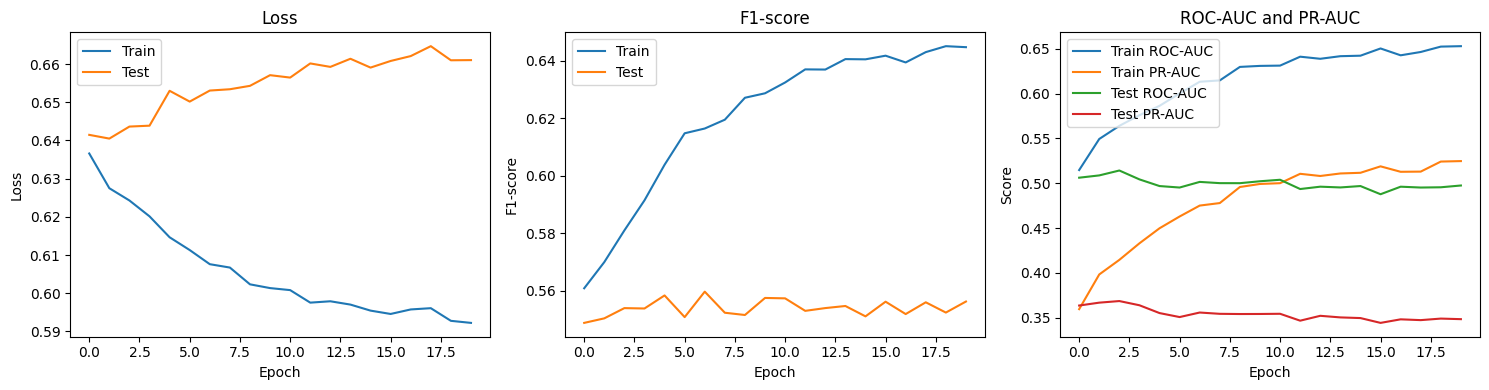

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_996/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_996/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6400, Train F1-score: 0.5584, Train ROC-AUC: 0.5080, Train PR-AUC: 0.3543, Test Loss: 0.6424, Test F1-score: 0.5374, Test ROC-AUC: 0.5044, Test PR-AUC: 0.3602
Epoch [2/30], Train Loss: 0.6316, Train F1-score: 0.5602, Train ROC-AUC: 0.5275, Train PR-AUC: 0.3848, Test Loss: 0.6395, Test F1-score: 0.5447, Test ROC-AUC: 0.5097, Test PR-AUC: 0.3687
Epoch [3/30], Train Loss: 0.6284, Train F1-score: 0.5713, Train ROC-AUC: 0.5460, Train PR-AUC: 0.3950, Test Loss: 0.6410, Test F1-score: 0.5473, Test ROC-AUC: 0.5153, Test PR-AUC: 0.3708
Epoch [4/30], Train Loss: 0.6230, Train F1-score: 0.5756, Train ROC-AUC: 0.5679, Train PR-AUC: 0.4180, Test Loss: 0.6465, Test F1-score: 0.5494, Test ROC-AUC: 0.5128, Test PR-AUC: 0.3676
Epoch [5/30], Train Loss: 0.6222, Train F1-score: 0.5834, Train ROC-AUC: 0.5688, Train PR-AUC: 0.4218, Test Loss: 0.6482, Test F1-score: 0.5526, Test ROC-AUC: 0.5091, Test PR-AUC: 0.3653
Epoch [6/30], Train Loss: 0.6171, Train F1-score: 0.5910, Train R

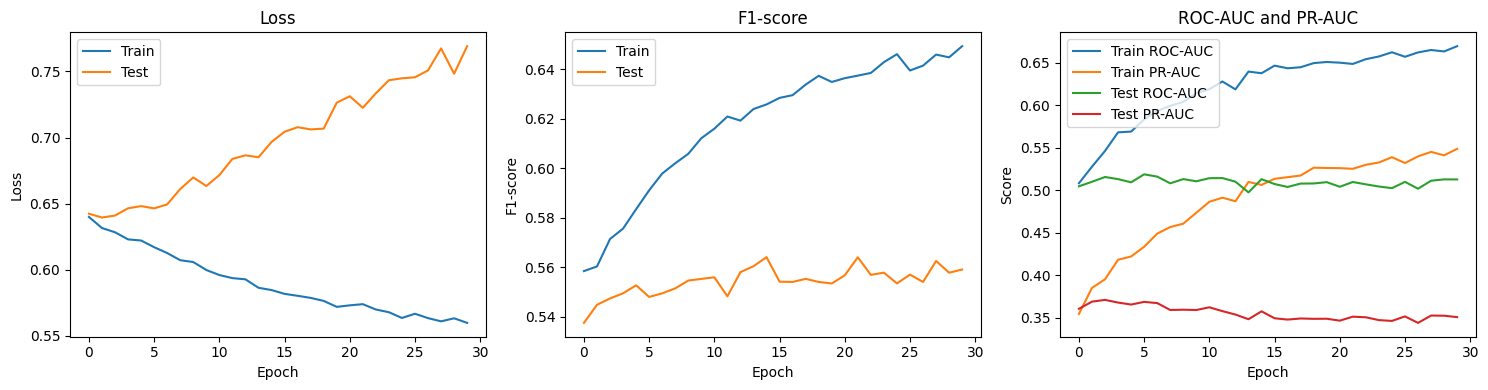

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

/tmp/ipykernel_996/140274637.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_996/140274637.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.53it/s]


Epoch [1/20], Train Loss: 0.6374, Train F1-score: 0.5527, Train ROC-AUC: 0.5220, Train PR-AUC: 0.3625, Test Loss: 0.6425, Test F1-score: 0.5363, Test ROC-AUC: 0.5147, Test PR-AUC: 0.3650


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.21it/s]


Epoch [2/20], Train Loss: 0.6326, Train F1-score: 0.5606, Train ROC-AUC: 0.5343, Train PR-AUC: 0.3856, Test Loss: 0.6429, Test F1-score: 0.5460, Test ROC-AUC: 0.5138, Test PR-AUC: 0.3672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.89it/s]


Epoch [3/20], Train Loss: 0.6294, Train F1-score: 0.5694, Train ROC-AUC: 0.5404, Train PR-AUC: 0.3921, Test Loss: 0.6424, Test F1-score: 0.5494, Test ROC-AUC: 0.5176, Test PR-AUC: 0.3712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.13it/s]


Epoch [4/20], Train Loss: 0.6266, Train F1-score: 0.5742, Train ROC-AUC: 0.5514, Train PR-AUC: 0.4013, Test Loss: 0.6444, Test F1-score: 0.5473, Test ROC-AUC: 0.5126, Test PR-AUC: 0.3657


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.31it/s]


Epoch [5/20], Train Loss: 0.6210, Train F1-score: 0.5831, Train ROC-AUC: 0.5706, Train PR-AUC: 0.4229, Test Loss: 0.6506, Test F1-score: 0.5544, Test ROC-AUC: 0.5024, Test PR-AUC: 0.3564


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.64it/s]


Epoch [6/20], Train Loss: 0.6175, Train F1-score: 0.5888, Train ROC-AUC: 0.5789, Train PR-AUC: 0.4287, Test Loss: 0.6513, Test F1-score: 0.5504, Test ROC-AUC: 0.5061, Test PR-AUC: 0.3548


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.92it/s]


Epoch [7/20], Train Loss: 0.6139, Train F1-score: 0.5925, Train ROC-AUC: 0.5808, Train PR-AUC: 0.4356, Test Loss: 0.6671, Test F1-score: 0.5534, Test ROC-AUC: 0.5097, Test PR-AUC: 0.3578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.25it/s]


Epoch [8/20], Train Loss: 0.6101, Train F1-score: 0.5976, Train ROC-AUC: 0.5942, Train PR-AUC: 0.4489, Test Loss: 0.6517, Test F1-score: 0.5568, Test ROC-AUC: 0.4972, Test PR-AUC: 0.3528


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.23it/s]


Epoch [9/20], Train Loss: 0.6036, Train F1-score: 0.6067, Train ROC-AUC: 0.6046, Train PR-AUC: 0.4632, Test Loss: 0.6724, Test F1-score: 0.5558, Test ROC-AUC: 0.4987, Test PR-AUC: 0.3513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.11it/s]


Epoch [10/20], Train Loss: 0.5997, Train F1-score: 0.6089, Train ROC-AUC: 0.6052, Train PR-AUC: 0.4684, Test Loss: 0.6680, Test F1-score: 0.5516, Test ROC-AUC: 0.5109, Test PR-AUC: 0.3534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.37it/s]


Epoch [11/20], Train Loss: 0.5946, Train F1-score: 0.6130, Train ROC-AUC: 0.6075, Train PR-AUC: 0.4770, Test Loss: 0.6725, Test F1-score: 0.5481, Test ROC-AUC: 0.5052, Test PR-AUC: 0.3488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.88it/s]


Epoch [12/20], Train Loss: 0.5906, Train F1-score: 0.6197, Train ROC-AUC: 0.6212, Train PR-AUC: 0.4893, Test Loss: 0.6915, Test F1-score: 0.5533, Test ROC-AUC: 0.5044, Test PR-AUC: 0.3485


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 74.14it/s]


Epoch [13/20], Train Loss: 0.5884, Train F1-score: 0.6230, Train ROC-AUC: 0.6265, Train PR-AUC: 0.4928, Test Loss: 0.7179, Test F1-score: 0.5585, Test ROC-AUC: 0.5036, Test PR-AUC: 0.3501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.49it/s]


Epoch [14/20], Train Loss: 0.5831, Train F1-score: 0.6277, Train ROC-AUC: 0.6277, Train PR-AUC: 0.5037, Test Loss: 0.7158, Test F1-score: 0.5542, Test ROC-AUC: 0.5111, Test PR-AUC: 0.3551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.75it/s]


Epoch [15/20], Train Loss: 0.5812, Train F1-score: 0.6270, Train ROC-AUC: 0.6321, Train PR-AUC: 0.5030, Test Loss: 0.7216, Test F1-score: 0.5509, Test ROC-AUC: 0.4939, Test PR-AUC: 0.3412


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.32it/s]


Epoch [16/20], Train Loss: 0.5791, Train F1-score: 0.6296, Train ROC-AUC: 0.6334, Train PR-AUC: 0.5096, Test Loss: 0.7338, Test F1-score: 0.5557, Test ROC-AUC: 0.5091, Test PR-AUC: 0.3529


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.99it/s]


Epoch [17/20], Train Loss: 0.5753, Train F1-score: 0.6308, Train ROC-AUC: 0.6311, Train PR-AUC: 0.5100, Test Loss: 0.7389, Test F1-score: 0.5539, Test ROC-AUC: 0.5095, Test PR-AUC: 0.3508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.43it/s]


Epoch [18/20], Train Loss: 0.5725, Train F1-score: 0.6346, Train ROC-AUC: 0.6379, Train PR-AUC: 0.5146, Test Loss: 0.7663, Test F1-score: 0.5566, Test ROC-AUC: 0.5145, Test PR-AUC: 0.3562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.05it/s]


Epoch [19/20], Train Loss: 0.5729, Train F1-score: 0.6337, Train ROC-AUC: 0.6354, Train PR-AUC: 0.5119, Test Loss: 0.7732, Test F1-score: 0.5566, Test ROC-AUC: 0.5072, Test PR-AUC: 0.3508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:08<00:00, 73.81it/s]


Epoch [20/20], Train Loss: 0.5681, Train F1-score: 0.6371, Train ROC-AUC: 0.6423, Train PR-AUC: 0.5226, Test Loss: 0.7833, Test F1-score: 0.5523, Test ROC-AUC: 0.5095, Test PR-AUC: 0.3489


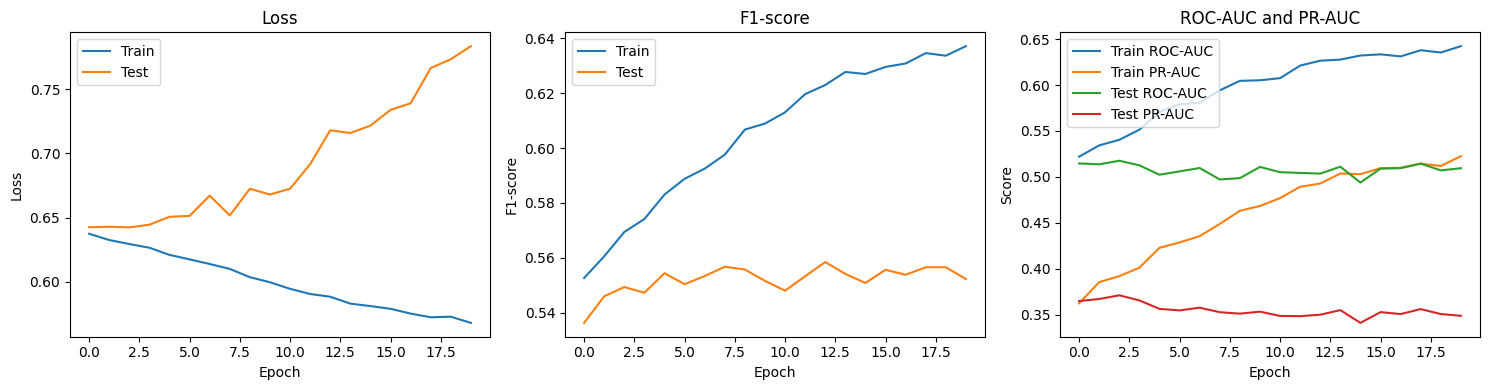

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 128
output_size = 2

model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)

        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)

        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.6788, Train F1-score: 0.5564, Train ROC-AUC: 0.5074, Train PR-AUC: 0.3480, Test Loss: 0.6690, Test F1-score: 0.5385, Test ROC-AUC: 0.4948, Test PR-AUC: 0.3423
Epoch [2/50], Train Loss: 0.6662, Train F1-score: 0.5546, Train ROC-AUC: 0.5124, Train PR-AUC: 0.3538, Test Loss: 0.6606, Test F1-score: 0.5369, Test ROC-AUC: 0.4997, Test PR-AUC: 0.3451
Epoch [3/50], Train Loss: 0.6556, Train F1-score: 0.5524, Train ROC-AUC: 0.5102, Train PR-AUC: 0.3560, Test Loss: 0.6538, Test F1-score: 0.5316, Test ROC-AUC: 0.5042, Test PR-AUC: 0.3482
Epoch [4/50], Train Loss: 0.6474, Train F1-score: 0.5503, Train ROC-AUC: 0.5107, Train PR-AUC: 0.3575, Test Loss: 0.6482, Test F1-score: 0.5332, Test ROC-AUC: 0.5055, Test PR-AUC: 0.3513
Epoch [5/50], Train Loss: 0.6406, Train F1-score: 0.5504, Train ROC-AUC: 0.5114, Train PR-AUC: 0.3575, Test Loss: 0.6442, Test F1-score: 0.5323, Test ROC-AUC: 0.5101, Test PR-AUC: 0.3556
Epoch [6/50], Train Loss: 0.6356, Train F1-score: 0.5502, Train R

Epoch [48/50], Train Loss: 0.6065, Train F1-score: 0.5909, Train ROC-AUC: 0.5993, Train PR-AUC: 0.4542, Test Loss: 0.6527, Test F1-score: 0.5481, Test ROC-AUC: 0.5178, Test PR-AUC: 0.3639
Epoch [49/50], Train Loss: 0.6060, Train F1-score: 0.5914, Train ROC-AUC: 0.6004, Train PR-AUC: 0.4557, Test Loss: 0.6530, Test F1-score: 0.5481, Test ROC-AUC: 0.5163, Test PR-AUC: 0.3629
Epoch [50/50], Train Loss: 0.6055, Train F1-score: 0.5926, Train ROC-AUC: 0.6018, Train PR-AUC: 0.4573, Test Loss: 0.6535, Test F1-score: 0.5481, Test ROC-AUC: 0.5168, Test PR-AUC: 0.3630


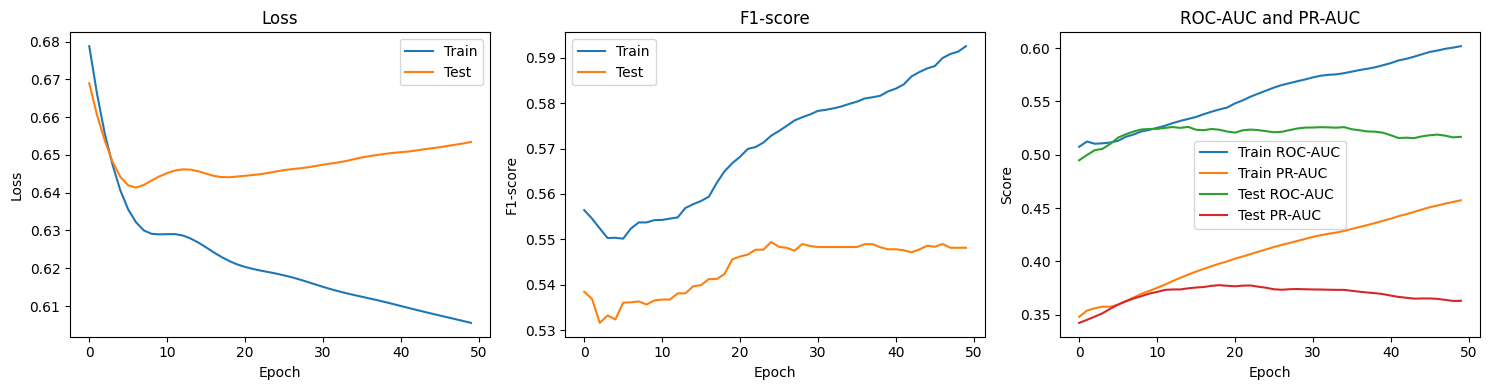

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [37]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [38]:
df_x

,Histone_H3K36me3,Histone_H3K18ub,Histone_H4K20me3,Histone_H2BK120ub,Histone_H4K20me2,Histone_H3K36me2,Histone_H4K20me1,Histone_H3K27ac,Histone_H2A.X,Histone_H3.Y,...,TFs_ZBTB17,TFs_ZBTB48,TFs_ZBTB7A,TFs_ZFP36,TFs_ZHX1,TFs_ZKSCAN1,TFs_ZMYND8,TFs_ZNF143,TFs_ZNF274,TFs_ZZZ3
0,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.194777,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
1,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.227065,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
2,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.372556,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
3,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.372556,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
4,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.318727,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12436,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.372556,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
12437,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.372556,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
12438,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.372556,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902
12439,-0.103094,-0.016362,-0.084447,-0.018304,-0.054437,-0.077704,-0.091148,-0.372556,-0.074445,-0.182317,...,-0.035561,-0.163355,-0.1278,-0.048473,-0.041469,-0.081286,-0.051238,-0.079699,-0.04047,-0.044902


In [39]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [40]:
df_y

,target
0,0
1,1
2,1
3,0
4,0
...,...
12436,0
12437,0
12438,0
12439,0


In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_
for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_996/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.011786827338490721
Histone_H3K18ub: 6.712042049700053e-06
Histone_H4K20me3: 0.001231907907879315
Histone_H2BK120ub: 0.0
Histone_H4K20me2: 0.0002737736680482715
Histone_H3K36me2: 0.0010893344071298719
Histone_H4K20me1: 0.00469342295293816
Histone_H3K27ac: 0.10939046862818158
Histone_H2A.X: 0.0015907754190140585
Histone_H3.Y: 0.0034417492154785122
Histone_H3K9me3: 0.03990714216158865
Histone_H3K9me2: 0.0003385566278295567
Histone_H2A.Z: 0.006956898137046533
Histone_H3K18ac: 0.003145780378793325
Histone_CENPA: 0.002813432392437616
Histone_H3: 0.05000188710456466
Histone_H3K79me3: 0.0064673302924548445
Histone_H3K79me2: 0.0020837807643034486
Histone_H3R3me2: 2.877874870148782e-06
Histone_H2A.Z.2: 2.1508253491271734e-05
Histone_H3K9K14ac: 0.0012846531817620477
Histone_H2A.Zac: 0.007711491077126421
Histone_H2A.XS139ph: 0.03513725816173067
Histone_H4ac: 0.0011866422239566515
Histone_H2A.Z.1: 0.0004556473059782694
Histone_H3K9ac: 0.00525545857851768
Histone_H3K4me2: 0.01087

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_996/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.2119
ROC-AUC: 0.4923
PR-AUC: 0.3816


               feature  importance
7      Histone_H3K27ac    0.107062
28     Histone_H3K4me3    0.064346
15          Histone_H3    0.048882
10     Histone_H3K9me3    0.038938
30     Histone_H3K4me1    0.036673
..                 ...         ...
219          TFs_TFB2M    0.000000
3    Histone_H2BK120ub    0.000000
40   Histone_H2AK119Ub    0.000000
175         TFs_POLRMT    0.000000
76          TFs_DYRK1A    0.000000

[244 rows x 2 columns]


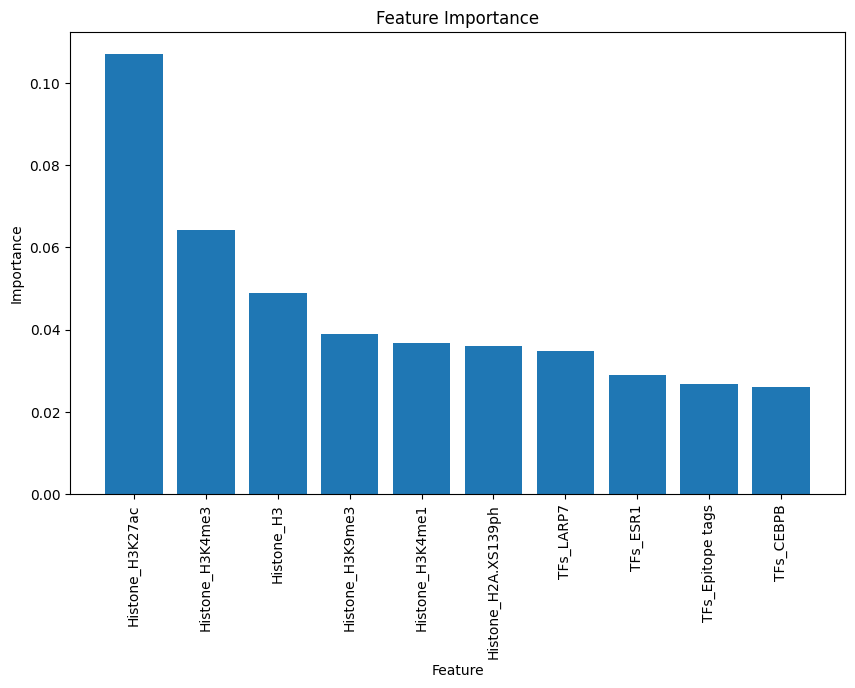

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [44]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6816552	total: 53.5ms	remaining: 53.4s
1:	learn: 0.6721655	total: 59.1ms	remaining: 29.5s
2:	learn: 0.6647366	total: 64.6ms	remaining: 21.5s
3:	learn: 0.6587497	total: 70.5ms	remaining: 17.5s
4:	learn: 0.6537861	total: 76.2ms	remaining: 15.2s
5:	learn: 0.6497127	total: 81.8ms	remaining: 13.5s
6:	learn: 0.6463963	total: 87.2ms	remaining: 12.4s
7:	learn: 0.6433541	total: 92.9ms	remaining: 11.5s
8:	learn: 0.6409368	total: 98.8ms	remaining: 10.9s
9:	learn: 0.6390979	total: 105ms	remaining: 10.4s
10:	learn: 0.6376651	total: 110ms	remaining: 9.92s
11:	learn: 0.6364735	total: 116ms	remaining: 9.55s
12:	learn: 0.6354028	total: 122ms	remaining: 9.24s
13:	learn: 0.6345553	total: 127ms	remaining: 8.95s
14:	learn: 0.6337997	total: 134ms	remaining: 8.79s
15:	learn: 0.6329938	total: 140ms	remaining: 8.59s
16:	learn: 0.6321979	total: 145ms	remaining: 8.39s
17:	learn: 0.6316557	total: 151ms	remaining: 8.22s
18:	learn: 0.6310949	total: 156ms	remaining: 8.06s
19:	learn: 0.6303315	total: 162m

172:	learn: 0.5789671	total: 1.05s	remaining: 5.04s
173:	learn: 0.5787665	total: 1.06s	remaining: 5.03s
174:	learn: 0.5785680	total: 1.06s	remaining: 5.02s
175:	learn: 0.5782888	total: 1.07s	remaining: 5.01s
176:	learn: 0.5779160	total: 1.08s	remaining: 5.01s
177:	learn: 0.5775542	total: 1.08s	remaining: 5s
178:	learn: 0.5769697	total: 1.09s	remaining: 4.99s
179:	learn: 0.5765747	total: 1.09s	remaining: 4.99s
180:	learn: 0.5761675	total: 1.1s	remaining: 4.98s
181:	learn: 0.5757571	total: 1.11s	remaining: 4.97s
182:	learn: 0.5753858	total: 1.11s	remaining: 4.97s
183:	learn: 0.5749323	total: 1.12s	remaining: 4.96s
184:	learn: 0.5746300	total: 1.12s	remaining: 4.95s
185:	learn: 0.5743100	total: 1.13s	remaining: 4.94s
186:	learn: 0.5739145	total: 1.14s	remaining: 4.94s
187:	learn: 0.5736803	total: 1.14s	remaining: 4.93s
188:	learn: 0.5734458	total: 1.15s	remaining: 4.93s
189:	learn: 0.5732619	total: 1.15s	remaining: 4.92s
190:	learn: 0.5731210	total: 1.16s	remaining: 4.91s
191:	learn: 0.57

342:	learn: 0.5403381	total: 2.05s	remaining: 3.92s
343:	learn: 0.5399630	total: 2.05s	remaining: 3.91s
344:	learn: 0.5396679	total: 2.06s	remaining: 3.91s
345:	learn: 0.5396135	total: 2.06s	remaining: 3.9s
346:	learn: 0.5393100	total: 2.07s	remaining: 3.89s
347:	learn: 0.5391472	total: 2.08s	remaining: 3.89s
348:	learn: 0.5389031	total: 2.08s	remaining: 3.88s
349:	learn: 0.5385135	total: 2.09s	remaining: 3.88s
350:	learn: 0.5380970	total: 2.09s	remaining: 3.87s
351:	learn: 0.5378984	total: 2.1s	remaining: 3.86s
352:	learn: 0.5376641	total: 2.1s	remaining: 3.86s
353:	learn: 0.5374467	total: 2.11s	remaining: 3.85s
354:	learn: 0.5372699	total: 2.12s	remaining: 3.85s
355:	learn: 0.5371481	total: 2.12s	remaining: 3.84s
356:	learn: 0.5367866	total: 2.13s	remaining: 3.83s
357:	learn: 0.5365829	total: 2.13s	remaining: 3.83s
358:	learn: 0.5365609	total: 2.14s	remaining: 3.82s
359:	learn: 0.5361317	total: 2.15s	remaining: 3.81s
360:	learn: 0.5359775	total: 2.15s	remaining: 3.81s
361:	learn: 0.5

514:	learn: 0.5114646	total: 3.04s	remaining: 2.87s
515:	learn: 0.5113394	total: 3.05s	remaining: 2.86s
516:	learn: 0.5112657	total: 3.06s	remaining: 2.85s
517:	learn: 0.5111181	total: 3.06s	remaining: 2.85s
518:	learn: 0.5109605	total: 3.07s	remaining: 2.84s
519:	learn: 0.5108703	total: 3.07s	remaining: 2.84s
520:	learn: 0.5107583	total: 3.08s	remaining: 2.83s
521:	learn: 0.5106202	total: 3.08s	remaining: 2.83s
522:	learn: 0.5105297	total: 3.09s	remaining: 2.82s
523:	learn: 0.5103485	total: 3.1s	remaining: 2.81s
524:	learn: 0.5100749	total: 3.1s	remaining: 2.81s
525:	learn: 0.5099837	total: 3.11s	remaining: 2.8s
526:	learn: 0.5098533	total: 3.11s	remaining: 2.79s
527:	learn: 0.5096204	total: 3.12s	remaining: 2.79s
528:	learn: 0.5094689	total: 3.12s	remaining: 2.78s
529:	learn: 0.5093850	total: 3.13s	remaining: 2.78s
530:	learn: 0.5091272	total: 3.14s	remaining: 2.77s
531:	learn: 0.5090606	total: 3.14s	remaining: 2.76s
532:	learn: 0.5089494	total: 3.15s	remaining: 2.76s
533:	learn: 0.5

687:	learn: 0.4904103	total: 4.04s	remaining: 1.83s
688:	learn: 0.4903080	total: 4.05s	remaining: 1.83s
689:	learn: 0.4899190	total: 4.05s	remaining: 1.82s
690:	learn: 0.4897941	total: 4.06s	remaining: 1.81s
691:	learn: 0.4897639	total: 4.07s	remaining: 1.81s
692:	learn: 0.4897069	total: 4.07s	remaining: 1.8s
693:	learn: 0.4895229	total: 4.08s	remaining: 1.8s
694:	learn: 0.4895107	total: 4.08s	remaining: 1.79s
695:	learn: 0.4892910	total: 4.09s	remaining: 1.78s
696:	learn: 0.4891815	total: 4.09s	remaining: 1.78s
697:	learn: 0.4891120	total: 4.1s	remaining: 1.77s
698:	learn: 0.4890328	total: 4.11s	remaining: 1.77s
699:	learn: 0.4887571	total: 4.11s	remaining: 1.76s
700:	learn: 0.4886512	total: 4.12s	remaining: 1.76s
701:	learn: 0.4885118	total: 4.12s	remaining: 1.75s
702:	learn: 0.4884550	total: 4.13s	remaining: 1.74s
703:	learn: 0.4883065	total: 4.13s	remaining: 1.74s
704:	learn: 0.4881936	total: 4.14s	remaining: 1.73s
705:	learn: 0.4879869	total: 4.14s	remaining: 1.73s
706:	learn: 0.4

862:	learn: 0.4725124	total: 5.05s	remaining: 802ms
863:	learn: 0.4724540	total: 5.06s	remaining: 796ms
864:	learn: 0.4723941	total: 5.06s	remaining: 790ms
865:	learn: 0.4723548	total: 5.07s	remaining: 784ms
866:	learn: 0.4722264	total: 5.08s	remaining: 779ms
867:	learn: 0.4721173	total: 5.08s	remaining: 773ms
868:	learn: 0.4720763	total: 5.09s	remaining: 767ms
869:	learn: 0.4720641	total: 5.09s	remaining: 761ms
870:	learn: 0.4719780	total: 5.1s	remaining: 755ms
871:	learn: 0.4718231	total: 5.1s	remaining: 749ms
872:	learn: 0.4717646	total: 5.11s	remaining: 743ms
873:	learn: 0.4716167	total: 5.12s	remaining: 737ms
874:	learn: 0.4715870	total: 5.12s	remaining: 732ms
875:	learn: 0.4714872	total: 5.13s	remaining: 726ms
876:	learn: 0.4713900	total: 5.13s	remaining: 720ms
877:	learn: 0.4713182	total: 5.14s	remaining: 714ms
878:	learn: 0.4712496	total: 5.14s	remaining: 708ms
879:	learn: 0.4711829	total: 5.15s	remaining: 702ms
880:	learn: 0.4710648	total: 5.16s	remaining: 696ms
881:	learn: 0.

In [45]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 0.5506784129555674
Histone_H3K18ub: 0.0
Histone_H4K20me3: 0.03224472265789063
Histone_H2BK120ub: 0.0
Histone_H4K20me2: 0.0
Histone_H3K36me2: 0.08623045735757807
Histone_H4K20me1: 0.30937111460741096
Histone_H3K27ac: 7.9742610362200095
Histone_H2A.X: 0.057841292964012324
Histone_H3.Y: 0.4565316638922344
Histone_H3K9me3: 2.41701150001658
Histone_H3K9me2: 0.016704330776092853
Histone_H2A.Z: 1.0331802057933641
Histone_H3K18ac: 0.4485316376642969
Histone_CENPA: 0.7587482080866229
Histone_H3: 2.305948235903718
Histone_H3K79me3: 0.47687351124040434
Histone_H3K79me2: 0.2399280229050548
Histone_H3R3me2: 0.006292473172993187
Histone_H2A.Z.2: 0.0006917540672731317
Histone_H3K9K14ac: 0.18403698036829738
Histone_H2A.Zac: 1.0151081945739553
Histone_H2A.XS139ph: 3.192772007953431
Histone_H4ac: 0.037033094984580385
Histone_H2A.Z.1: 0.054551787923832376
Histone_H3K9ac: 0.5743207907391985
Histone_H3K4me2: 1.3816894495817118
Histone_H3R17me2: 0.0
Histone_H3K4me3: 4.781586517142405
Histo

              feature  importance
7     Histone_H3K27ac    7.974261
28    Histone_H3K4me3    4.781587
30    Histone_H3K4me1    4.402873
63          TFs_CEBPB    3.424048
88   TFs_Epitope tags    3.398012
..                ...         ...
221        TFs_THAP11    0.000000
222          TFs_TP63    0.000000
180         TFs_PRMT5    0.000000
224         TFs_TRRAP    0.000000
86          TFs_EPAS1    0.000000

[244 rows x 2 columns]


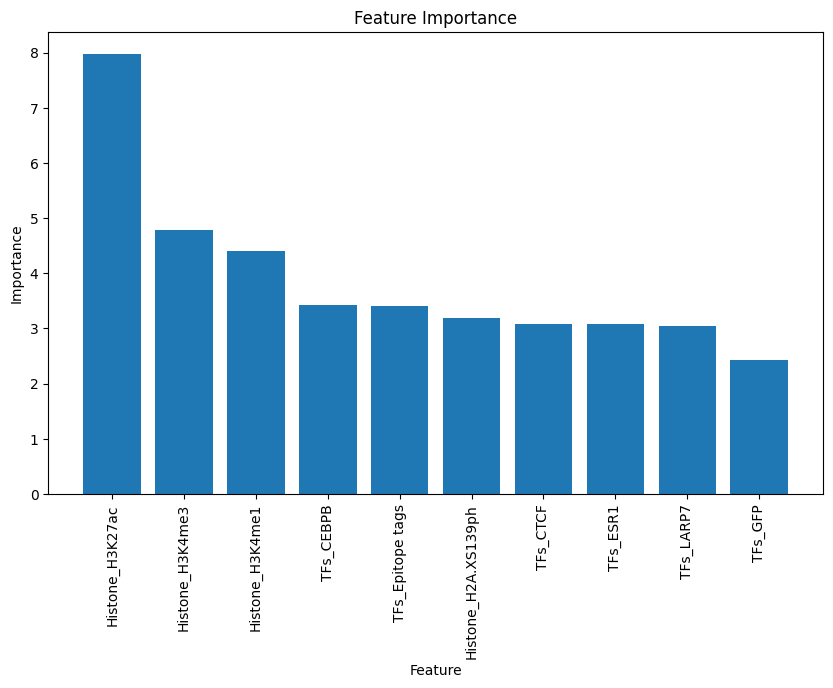

In [46]:
importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)
plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
